In [314]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Q1

## (a)

In [231]:
df = pd.read_csv("data/hh_inc_synth.txt", header=None)
df["hhi"] = df[0]/1000
# bins
q1_bins = [0,
4999, 9999, 
14999, 19999, 
24999, 29999, 
34999, 39999, 
44999, 49999, 
54999, 59999,
64999, 69999, 
74999, 79999,
84999, 89999, 
94999, 99999, 
104999, 109999, 
114999, 119999, 
124999, 129999, 
134999, 139999, 
144999, 149999, 
154999, 159999, 
164999, 169999, 
174999, 179999, 
184999, 189999, 
194999, 199999, 
249999, 350000]
q1_bins = [num/1000 for num in q1_bins]
hist, bin_edges = np.histogram(df.hhi, q1_bins)

## (b)

In [277]:
df["weight"] = 1/len(df)
df.loc[(df.hhi >= 199.99) & (df.hhi < 249.99), "weight"] = df.weight/10
df.loc[(df.hhi >= 249.99) & (df.hhi < 350), "weight"] = df.weight/20

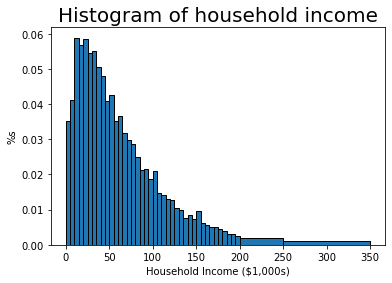

In [291]:
plt.hist(df.hhi, bins = bin_edges, weights = df.weight, edgecolor='k')
plt.title('Histogram of household income', fontsize=20)
plt.xlabel(r'Household Income ($1,000s)')
plt.ylabel(r'%s')
plt.show()

## (c):

In [481]:
def data_moments(df):
        q1_bins = [0,
        4999, 9999, 
        14999, 19999, 
        24999, 29999, 
        34999, 39999, 
        44999, 49999, 
        54999, 59999,
        64999, 69999, 
        74999, 79999,
        84999, 89999, 
        94999, 99999, 
        104999, 109999, 
        114999, 119999, 
        124999, 129999, 
        134999, 139999, 
        144999, 149999, 
        154999, 159999, 
        164999, 169999, 
        174999, 179999, 
        184999, 189999, 
        194999, 199999, 
        249999, 350000]
        q1_bins = [num/1000 for num in q1_bins]
        hist, bin_edges = np.histogram(df, q1_bins)

        return hist, bin_edges

def lognormal_pdf(x, mu, sigma):
    pdf = 1/x/sigma/np.sqrt(2*np.pi)*np.exp(-1*(np.log(x)-mu)**2/2/sigma**2)
    return pdf

def model_moments(mu, sigma, bin_edges):
    total_n = 121085
    mmdf = pd.DataFrame({"left_bound": bin_edges[:-1],
                    "right_bound":bin_edges[1:]})
    mmdf["mid"] = (mmdf.left_bound + mmdf.right_bound)/2
    for index, row in mmdf.iterrows():
        fx = lambda x: lognormal_pdf(x, mu, sigma)
        (model_cdf, trash) = intgr.quad(fx, row["left_bound"], row["right_bound"], limit = 200)
        mmdf.loc[index, "cdf"] =  model_cdf
    mmdf["n"] = mmdf.cdf*total_n
    return mmdf.n

def err_vec(xvals, mu, sigma, simple):
    data_vec, bin_edges = data_moments(xvals)
    model_vec = model_moments(mu, sigma, bin_edges)
    if simple:
        err_vec = model_vec - data_vec
    else:
        err_vec = (model_vec - data_vec) / model_vec
    
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals = args
    hist, trash = data_moments(xvals)
    W = np.diag(hist)
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    return crit_val


In [482]:
mu_init = np.mean(df.hhi)
sigma_init = 10
params_init = np.array([mu_init, sigma_init])
gmm_args = (df.hhi)
results = opt.minimize(criterion, 
    params_init, 
    args=(gmm_args), 
    tol=1e-10,
    method='L-BFGS-B', 
    bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


mu_GMM1= 56.025620666649104  sig_GMM1= 37.28449596144018


      fun: 1.157275714735769e+19
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.95227197e+18, 1.57033452e+18])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 354
      nit: 55
   status: 0
  success: True
        x: array([56.02562067, 37.28449596])

In [483]:
def create_midpoints(df):
    q1_bins = [0,
    4999, 9999, 
    14999, 19999, 
    24999, 29999, 
    34999, 39999, 
    44999, 49999, 
    54999, 59999,
    64999, 69999, 
    74999, 79999,
    84999, 89999, 
    94999, 99999, 
    104999, 109999, 
    114999, 119999, 
    124999, 129999, 
    134999, 139999, 
    144999, 149999, 
    154999, 159999, 
    164999, 169999, 
    174999, 179999, 
    184999, 189999, 
    194999, 199999, 
    249999, 350000]
    q1_bins = [num/1000 for num in q1_bins]
    hist, bin_edges = np.histogram(df, q1_bins)
    mmdf = pd.DataFrame({"left_bound": bin_edges[:-1],
                    "right_bound":bin_edges[1:]})
    mmdf["mid"] = (mmdf.left_bound + mmdf.right_bound)/2
    
    return mmdf["mid"]

In [441]:
mid_points = create_midpoints(df.hhi)

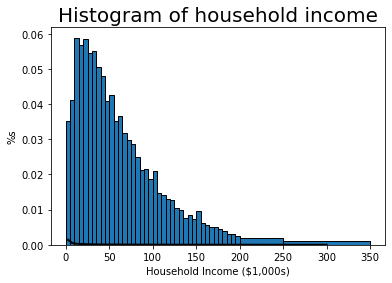

In [484]:
plt.hist(df.hhi, bins = bin_edges, weights = df.weight, edgecolor='k')
plt.title('Histogram of household income', fontsize=20)
plt.xlabel(r'Household Income ($1,000s)')
plt.ylabel(r'%s')
plt.plot(mid_points, lognormal_pdf(mid_points, mu_GMM1, sig_GMM1),
         linewidth=2, color='k', label='GMM')
plt.show()

In [485]:
lognormal_pdf(mid_points*1000, mu_GMM1, sig_GMM1)

0     1.856085e-06
1     6.423976e-07
2     3.921111e-07
3     2.832380e-07
4     2.221383e-07
5     1.829565e-07
6     1.556614e-07
7     1.355402e-07
8     1.200842e-07
9     1.078337e-07
10    9.788170e-08
11    8.963433e-08
12    8.268648e-08
13    7.675220e-08
14    7.162389e-08
15    6.714710e-08
16    6.320457e-08
17    5.970564e-08
18    5.657910e-08
19    5.376824e-08
20    5.122734e-08
21    4.891912e-08
22    4.681287e-08
23    4.488307e-08
24    4.310835e-08
25    4.147063e-08
26    3.995459e-08
27    3.854707e-08
28    3.723677e-08
29    3.601391e-08
30    3.486999e-08
31    3.379755e-08
32    3.279007e-08
33    3.184179e-08
34    3.094762e-08
35    3.010304e-08
36    2.930400e-08
37    2.854691e-08
38    2.782854e-08
39    2.714596e-08
40    2.392610e-08
41    1.810701e-08
Name: mid, dtype: float64

In [438]:
len(df)

121085

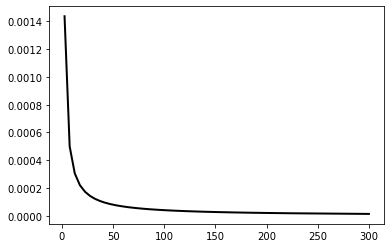

In [486]:
plt.plot(mid_points, lognormal_pdf(mid_points, mu_GMM1, sig_GMM1),
         linewidth=2, color='k', label='GMM')
plt.show()

In [462]:
xvals = df.hhi

In [463]:
data_vec, bin_edges = data_moments(xvals)

In [464]:
model_vec = model_moments(mu, sigma, bin_edges)

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


In [466]:
mmdf = pd.DataFrame({"left_bound": bin_edges[:-1],
                    "right_bound":bin_edges[1:]})

In [467]:
mmdf["mid"] = (mmdf.left_bound + mmdf.right_bound)/2

In [468]:
fx = lambda x: lognormal_pdf(x, mu, sigma)

In [469]:
mu = mu_GMM1
sigma = sig_GMM1

In [478]:
for index, row in mmdf.iterrows():
    (model_cdf, trash) = intgr.quad(fx, row["left_bound"], row["right_bound"], limit = 500)
    mmdf.loc[index, "cdf"] =  model_cdf

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  


In [479]:
sum(mmdf.cdf)

0.24527358971298452

In [480]:
intgr.quad(fx, row["left_bound"], row["right_bound"])

(0.002195805424363319, 2.4378337397249695e-17)

In [ ]:
(model_cdf, trash) = intgr.quad(fx, row["left_bound"], row["right_bound"], limit = 200)
mmdf.loc[index, "cdf"] =  model_cdf

In [492]:
err_vec = (model_vec - data_vec)/model_vec

In [493]:
W = np.diag(hist)

In [494]:
err_vec.T @ W @ err_vec

866141707.623024